In [18]:
# Regresión pulmonar para calcular la capacidad vital forzada (FVC)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats


In [15]:
# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')

Muestra de los datos
   edad      altura       peso        imc  genero       tabaquismo exposicion  \
0    40  176.396786  93.441666  23.583967   Mujer     Fumador leve      Media   
1    19  166.865721  72.683969  25.000664  Hombre            Nunca      Media   
2    84  151.291767  84.016668  30.676201   Mujer            Nunca      Media   
3    43  156.815397  89.255354  29.041344   Mujer            Nunca       Baja   
4    24  155.793126  91.344056  30.814998   Mujer  Fumador intenso      Media   

         fvc  
0  15.999402  
1  16.854993  
2  10.075587  
3  17.360260  
4   8.294996  

Estadísticas descriptivas
             edad      altura        peso         imc         fvc
count  500.000000  500.000000  500.000000  500.000000  500.000000
mean    50.834000  165.020416   79.113091   26.058961   12.724245
std     19.104251   11.249104   11.344882    4.803904    4.048774
min     18.000000  125.276986   43.772650   11.720565    1.772676
25%     35.000000  157.822958   71.429537   2

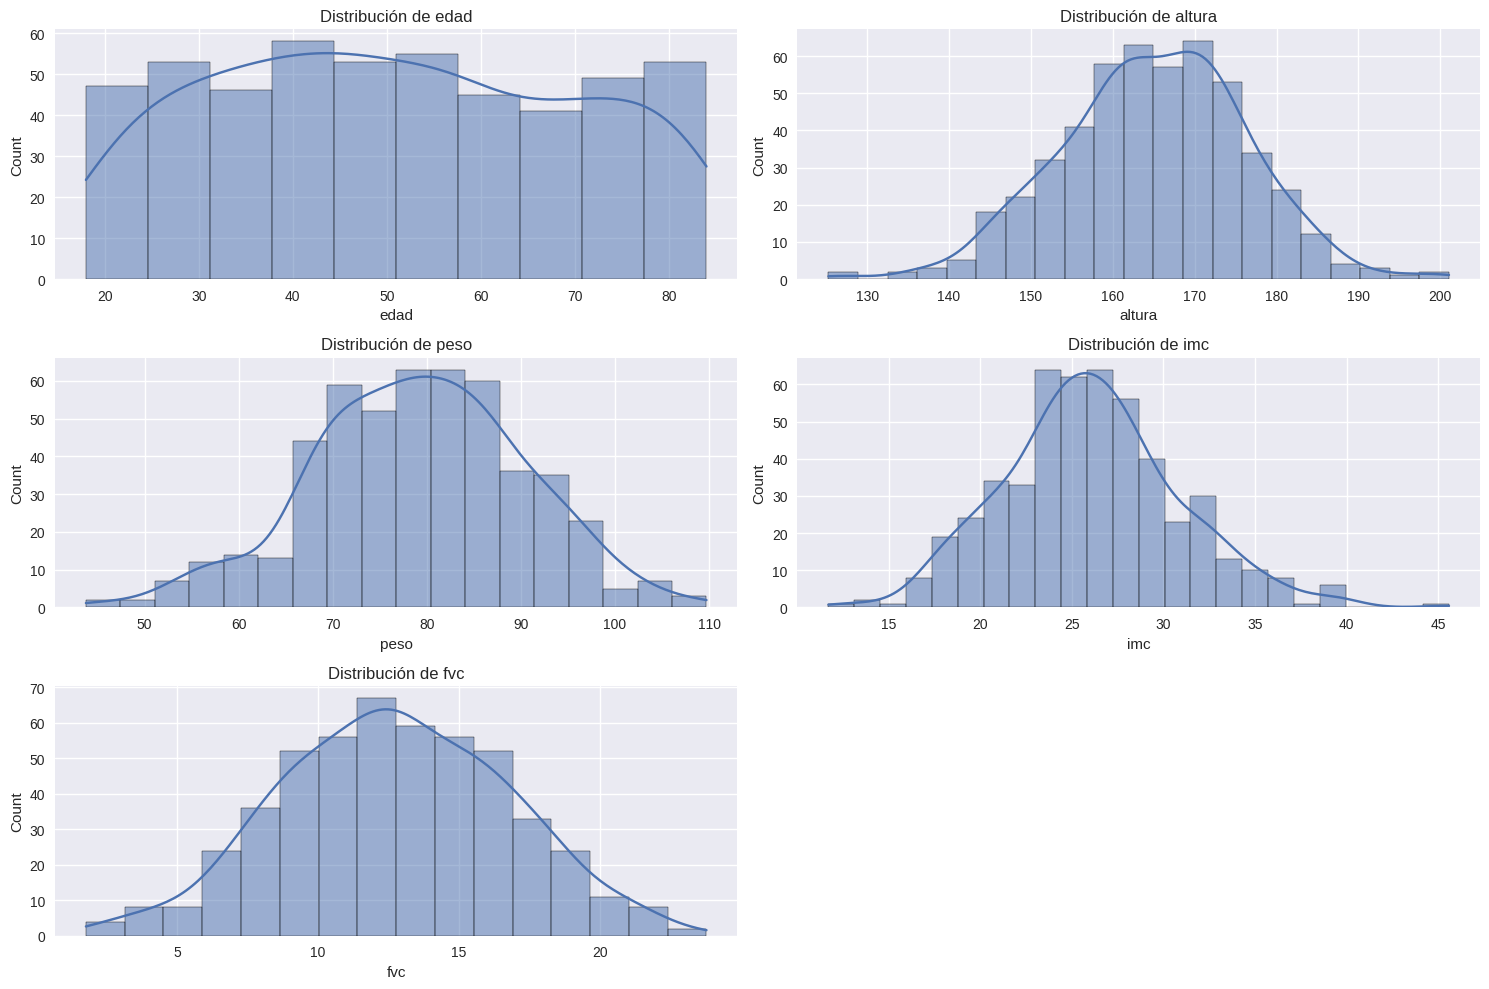

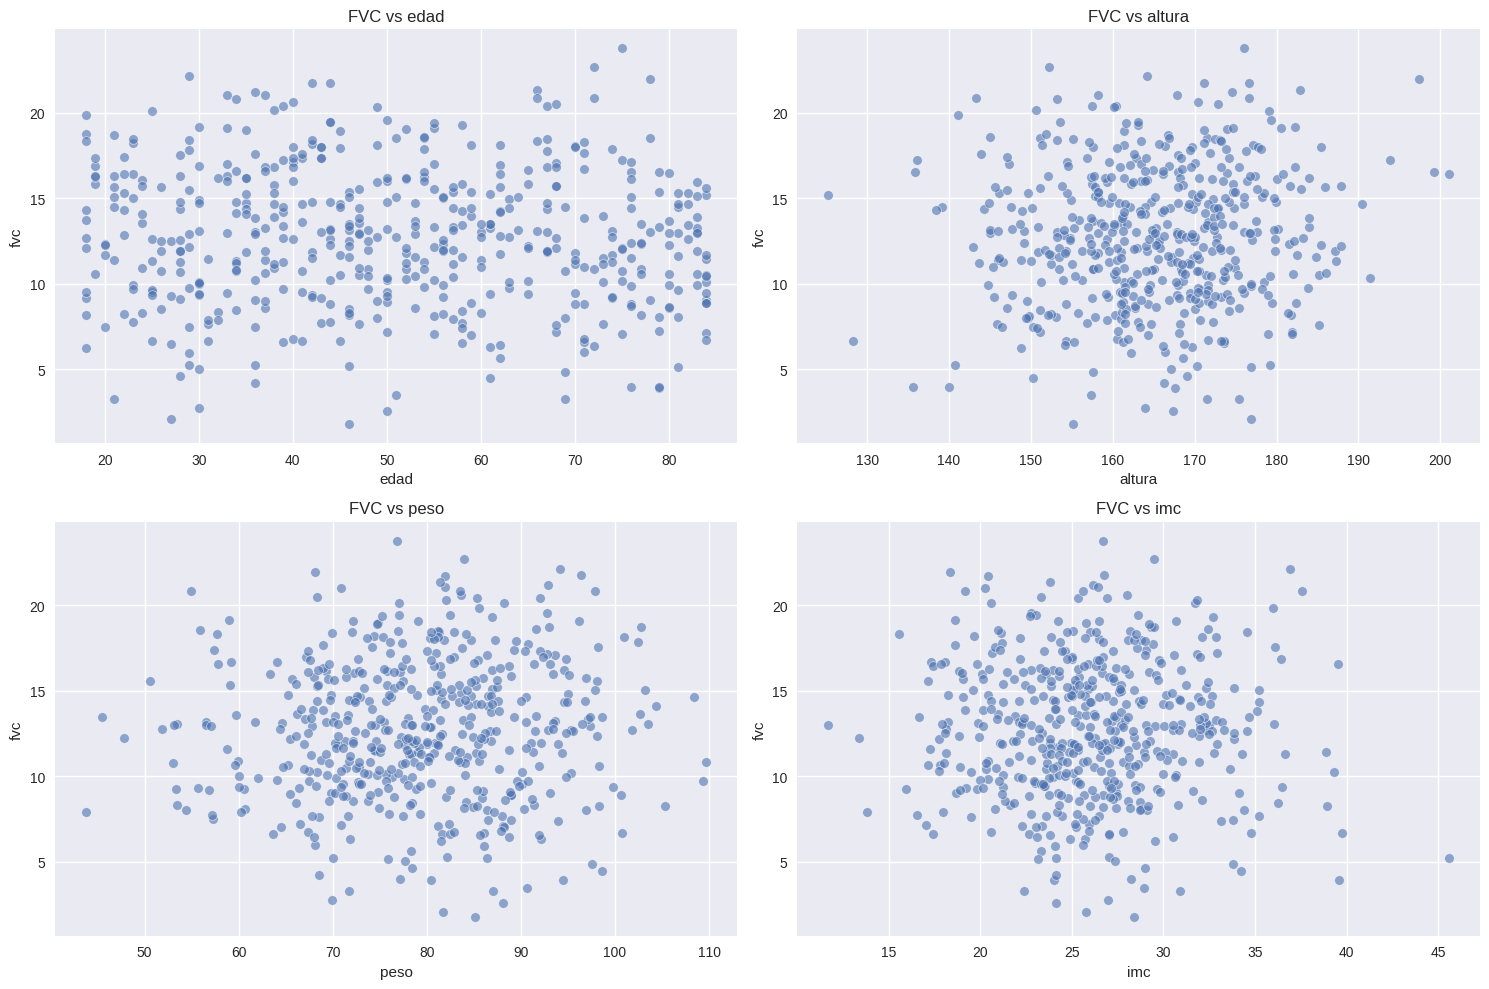

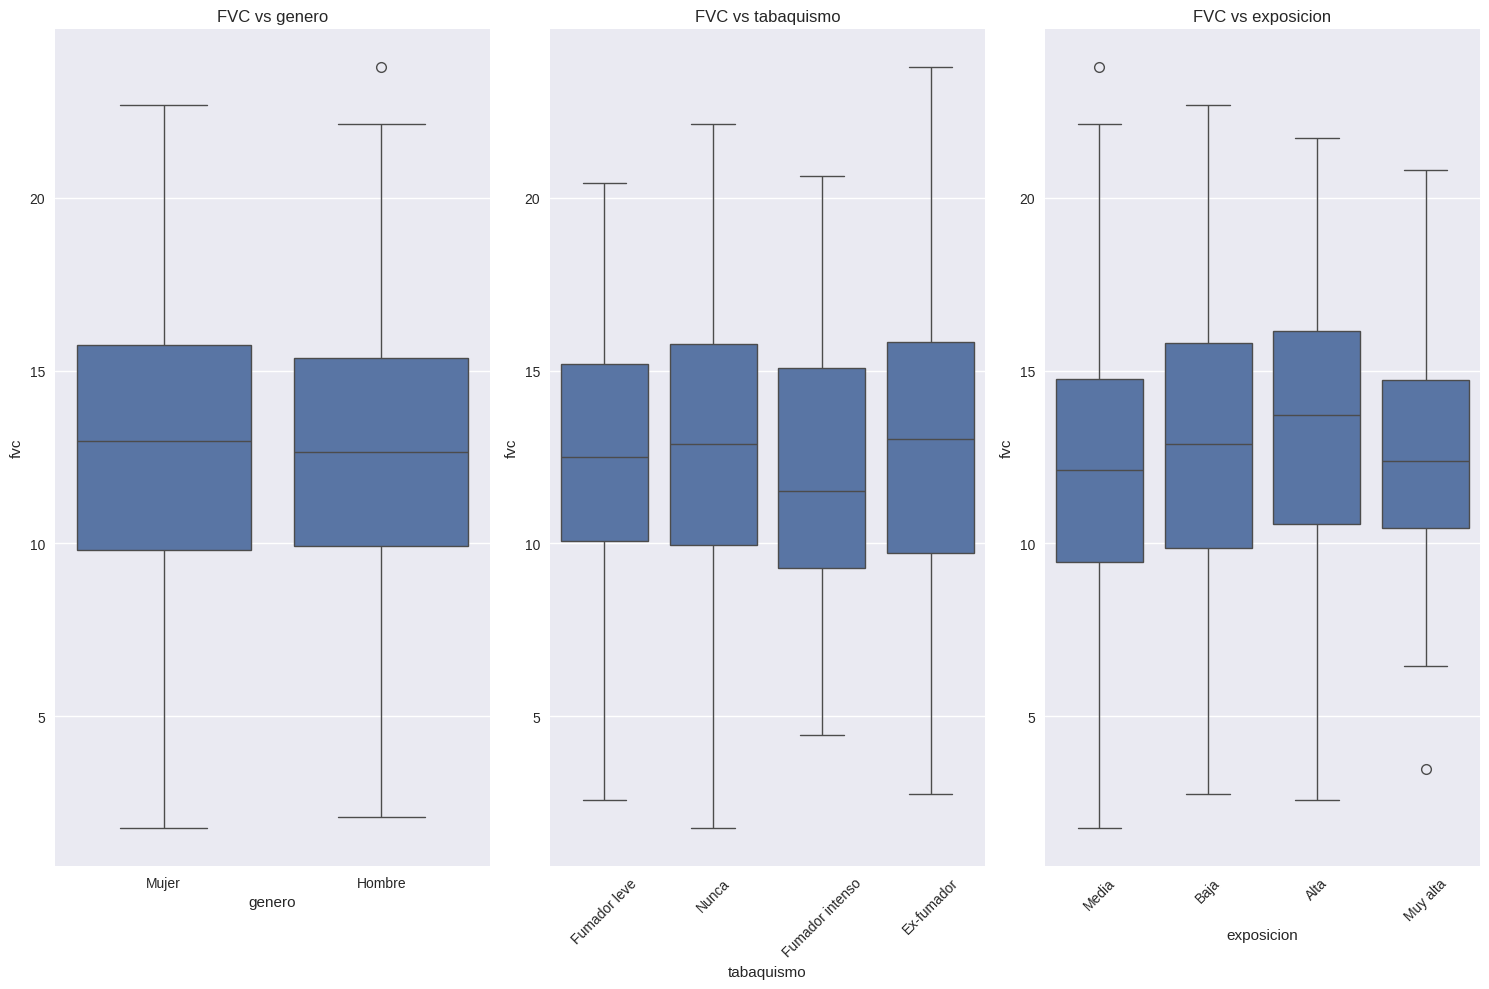

In [22]:
# Carga o generación de datos
def generar_datos_pulmonares(n=500):
  # variables demográficas
  edad = np.random.randint(18, 85, size=n)
  altura = np.random.normal(170, 10, size=n)
  peso = np.random.normal(75, 10, size=n)

  # Calculamos IMC para uso posterior
  imc = peso / ((altura / 100) ** 2)

  # Género (binario para simplificar)
  genero = np.random.choice([0, 1], size=n) # 0 : Mujer , 1 : Hombre

  # Ajsutamos altura y peso según género
  altura = altura - 10 * (1 - genero) + np.random.normal(0, 2, size=n)
  peso = peso + 8 * (1 - genero) + np.random.normal(0, 3, size=n)

  # Variables de exposición
  # indice de tabaquismo (0-3): 0=nunca, 1=ex-fumador, 2=fumador leve, 3=fumador intenso
  tabaquismo = np.random.choice([0, 1, 2, 3], size=n, p=[0.4,0.3,0.2,0.1])

  # Exposición a contaminantes (0-3): 0=baja, 1=media, 2=alta, 3=muy alta
  exposicion = np.random.choice([0, 1, 2, 3], size=n, p=[0.5,0.3,0.15,0.05])

  # Convertimos categóricas a string para mejor interpretabilidad
  tabaquismo_cat = np.array(['Nunca', 'Ex-fumador', 'Fumador leve', 'Fumador intenso'])[tabaquismo]
  exposicion_cat = np.array(['Baja', 'Media', 'Alta', 'Muy alta'])[exposicion]
  genero_cat = np.array(['Mujer', 'Hombre'])[genero]

  # Generamos el FVC (Capacidad Vital Forzada) en litros, basado en equaciones fisiologica
  base_fvc = (
      4.5 # valor base
      + 0.06 * altura # efecto positivo de la altura
      - 0.03 * edad # efecto negativo de la edad
      - 0.6 * genero # Efecto del género
      - 0.3 * tabaquismo # Efecto negativo del tabaquismo
      - 0.2 * exposicion # Efecto negativo de la exposición
      + 0.01 * (peso -imc) # Efecto complejo del peso
  )

  # Añadimos variabilidad aleatoria para simular diferencias individuales
  fvc = base_fvc + np.random.normal(0, 4, size=n)
  fvc = np.maximum(fvc, 1.0) # aseguramos valores mínimos realistas

  return pd.DataFrame({
      'edad': edad,
      'altura': altura,
      'peso': peso,
      'imc': imc,
      'genero': genero_cat,
      'tabaquismo': tabaquismo_cat,
      'exposicion': exposicion_cat,
      'fvc': fvc
  })
# Generamos el dataset
data = generar_datos_pulmonares(500)

# Exploración
print("Muestra de los datos")
print(data.head())

print("\nEstadísticas descriptivas")
print(data.describe())

print("\nDistribución de variables categóricas")
#print(data['genero'].value_counts())
#print(data['tabaquismo'].value_counts())
#print(data['exposicion'].value_counts())
for cat in ['genero', 'tabaquismo', 'exposicion']:
  print(f"\nDistribución de {cat}")
  print(data[cat].value_counts())

# Visualizamos distribuciones de variables numéricas
plt.figure(figsize=(15, 10))
numeric_vars = ['edad', 'altura', 'peso', 'imc', 'fvc']
for i, var in enumerate(numeric_vars, 1):
  plt.subplot(3, 2, i)
  sns.histplot(data[var], kde=True)
  plt.title(f'Distribución de {var}')
plt.tight_layout()
plt.savefig('distribuciones_pulmonares.png')

# Visualizamos relaciones bivariadas con FVC
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_vars[:-1], 1):
  plt.subplot(2, 2, i)
  sns.scatterplot(x=var, y='fvc', data=data, alpha=0.6)
  plt.title(f'FVC vs {var}')
plt.tight_layout()
plt.savefig('relaciones_fvc_numericas.png')

# Visualizamos relaciones categóricas con FVC
plt.figure(figsize=(15, 10))
categorical_vars = ['genero', 'tabaquismo', 'exposicion']
for i, var in enumerate(categorical_vars, 1):
  plt.subplot(1, 3, i)
  sns.boxplot(x=var, y='fvc', data=data)
  plt.title(f'FVC vs {var}')
  if var in ['tabaquismo', 'exposicion']:
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('relaciones_fvc_categoricas.png')

